<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: MIRI LRS Slit spectroscopy
# Step: photom() in Spec2Pipeline

<span style="color:red"> **Instruments Affected**</span>: MIRI 

### Table of Contents
<div style="text-align: left"> 

<br> [Imports](#imports_ID) <br> [Introduction](#intro_ID) <br> [Get Documentaion String for Markdown Blocks](#markdown_from_docs) <br> [Loading Data](#data_ID) <br> [Run JWST Pipeline](#pipeline_ID) <br> [Create Figure or Print Output](#residual_ID) <br> [About This Notebook](#about_ID) <br>

</div>

<a id="imports_ID"></a>
# Imports
List the library imports and why they are relevant to this notebook.


* os for simple operating system functions
* gwcs.wcstools for bounding box operations
* astropy.io for opening fits files
* inspect to get the docstring of our objects.
* IPython.display for printing markdown output
* jwst.datamodels for building model for JWST Pipeline
* jwst.module.PipelineStep is the pipeline step being tested
* matplotlib.pyplot to generate plot
* matplotlib.patches to plot shapes
* crds for retrieving a reference file


[Top of Page](#title_ID)

In [7]:
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import os
import glob
from scipy import interpolate
from IPython.display import Markdown
from jwst.pipeline import Detector1Pipeline, Spec2Pipeline, collect_pipeline_cfgs
from jwst.associations.asn_from_list import asn_from_list
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase
from jwst.background import BackgroundStep
from jwst.assign_wcs import AssignWcsStep
from jwst.extract_2d import Extract2dStep
from jwst.flatfield import FlatFieldStep
from jwst.photom import PhotomStep
from gwcs.wcstools import grid_from_bounding_box
import crds
from jwst import datamodels
from jwst.datamodels import ImageModel

from ci_watson.artifactory_helpers import get_bigdata

2021-01-25 10:48:59,485 - stpipe - WARNING - /Users/skendrew/anaconda3/envs/jwst0.17.1/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



<a id="intro_ID"></a>
# Introduction


For this test we are using the **photom** step for MIRI LRS slit data. For more information on the pipeline step visit the links below. 

Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/photom/main.html#imaging-and-non-ifu-spectroscopy

Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/photom



### Defining Term
Here is where you will define terms or acronymns that may not be known a general audience (ie a new employee to the institute or an external user). For example

- JWST: James Webb Space Telescope
- MIRI: Mid-Infrared Instrument
- LRS: Low Resolution Spectrometer


[Top of Page](#title_ID)

# Run Pipeline steps up to Photom

The simulated data were generated with MIRISim v2.3.0. The observation consists of an observation of a stellar source in the slit, using the ALONG-SLIT-NOD dither pattern. In this scenario, two exposures are executed with the target at 30 and 70% along the length of the slit. These two observations are subtracted from each other for background subtraction, then co-added in the 3rd stage of the pipeline.

In the first steps we run the Detector1 pipeline, and the Spec2 pipeline steps before **photom**.

In [8]:
if not os.path.exists('../cfg_files/'):
    os.mkdir('../cfg_files/')
    cfgs = collect_pipeline_cfgs.collect_pipeline_cfgs(dst='../cfg_files/')

In [9]:
Slitfile1 = get_bigdata('jwst_validation_notebooks',
                                     'validation_data',
                                     'calwebb_spec2',
                                    'spec2_miri_test',
                                    'miri_lrs_slit_pt_nod1_v2.3.fits')
 
Slitfile2 = get_bigdata('jwst_validation_notebooks',
                                     'validation_data',
                                     'calwebb_spec2',
                                    'spec2_miri_test',
                                    'miri_lrs_slit_pt_nod2_v2.3.fits')

files = [Slitfile1, Slitfile2]



## Detector1 Pipeline

In [10]:
det1 = []

# Run pipeline on both files
for ff in files:
    d1 = Detector1Pipeline.call(ff, save_results=True, config_file='../cfg_files/calwebb_detector1.cfg')
    det1.append(d1)

print(det1)

2021-01-25 10:50:51,139 - CRDS - ERROR -  Error determining best reference for 'pars-rscd_step'  =   Unknown reference type 'pars-rscd_step'
2021-01-25 10:50:51,182 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2021-01-25 10:50:51,184 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2021-01-25 10:50:51,186 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2021-01-25 10:50:51,189 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2021-01-25 10:50:51,191 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2021-01-25 10:50:51,193 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2021-01-25 10:50:51,195 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2021-01-25 10:50:51,196 - stpipe.Detector1Pipeline.rscd - INFO - RSCD_Step instance created.
2021-01-25 10:50:51,198 - stpipe.Detector1Pipeline.firstframe - INFO - First

2021-01-25 10:50:51,449 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/Users/skendrew//crds_cache/references/jwst/miri/jwst_miri_rscd_0010.fits'.
2021-01-25 10:50:51,450 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/Users/skendrew//crds_cache/references/jwst/miri/jwst_miri_saturation_0026.fits'.
2021-01-25 10:50:51,451 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2021-01-25 10:50:51,451 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2021-01-25 10:50:51,451 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2021-01-25 10:50:51,452 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2021-01-25 10:50:51,677 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).
2021-01-25 10:50:51,678 - stpipe.Detector1Pipel

2021-01-25 10:50:56,670 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=2, ngroups=10, nframes=1, groupgap=0
2021-01-25 10:50:56,670 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0
2021-01-25 10:50:58,250 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2021-01-25 10:50:58,535 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).
2021-01-25 10:50:58,536 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/skendrew/jwst_pipeline/jwst_validation_notebooks/jwst_validation_notebooks/photom', 'odd_even_columns': True, 'use_side_ref_pixe

2021-01-25 10:51:20,774 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2021-01-25 10:51:20,775 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2021-01-25 10:51:20,777 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2021-01-25 10:51:20,779 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2021-01-25 10:51:20,781 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2021-01-25 10:51:20,783 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2021-01-25 10:51:20,784 - stpipe.Detector1Pipeline.rscd - INFO - RSCD_Step instance created.
2021-01-25 10:51:20,785 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2021-01-25 10:51:20,786 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2021-01-25 10:51:20,787 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2021-

2021-01-25 10:51:21,028 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2021-01-25 10:51:21,028 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2021-01-25 10:51:21,029 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2021-01-25 10:51:21,029 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2021-01-25 10:51:21,194 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).
2021-01-25 10:51:21,196 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/skendrew/jwst_pipeline/jwst_validation_noteb

2021-01-25 10:51:25,933 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/skendrew/jwst_pipeline/jwst_validation_notebooks/jwst_validation_notebooks/photom', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}
2021-01-25 10:51:25,942 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True
2021-01-25 10:51:25,943 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True
2021-01-25 10:51:25,943 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11
2021-01-25 10:51:25,944 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.000000
2021-01-25 10:51:25,944 - stpipe.Detector1Pipeline.refpix - INFO - odd_ev

[<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>, <ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>]


## Spec2Pipeline

To run the Spec2Pipeline we first create an association file for the 2 exposures, assigning the nods as each others' backgrounds for background subtraction. We then run the Spec2Pipeline, skipping the final extract1d step.

In [11]:
asn_files = [det1[0].meta.filename, det1[1].meta.filename]
bgr_files = [det1[1].meta.filename, det1[0].meta.filename]

asn = asn_from_list(asn_files, rule=DMSLevel2bBase, meta={'program':'test', 'target':'bd60', 'asn_pool':'test'})

# now add the opposite nod as background exposure:
asn['products'][0]['members'].append({'expname':bgr_files[0], 'exptype':'background'})
asn['products'][1]['members'].append({'expname':bgr_files[1], 'exptype':'background'})

# write this out to a json file
with open('sp2-lrs-slit-test_asn.json', 'w') as fp:
    fp.write(asn.dump()[1])


2021-01-25 10:52:10,188 - stpipe - WARNING - /Users/skendrew/anaconda3/envs/jwst0.17.1/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



In [12]:
pipe2 = Spec2Pipeline()
pipe2.flat_field.save_results = True
pipe2.extract_1d.skip= True

sp2 = pipe2('sp2-lrs-slit-test_asn.json')
print(sp2)


2021-01-25 10:52:20,735 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2021-01-25 10:52:20,736 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2021-01-25 10:52:20,738 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2021-01-25 10:52:20,739 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2021-01-25 10:52:20,741 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2021-01-25 10:52:20,742 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2021-01-25 10:52:20,746 - stpipe.Spec2Pipeline.master_background - INFO - MasterBackgroundNrsSlitsStep instance created.
2021-01-25 10:52:20,748 - stpipe.Spec2Pipeline.master_background.flat_field - INFO - FlatFieldStep instance created.
2021-01-25 10:52:20,749 - stpipe.Spec2Pipeline.master_background.pathloss - INFO - PathLossStep instance created.
2021-01-25 10:52:20,751 - stpipe.Spec2Pipeline.master_

2021-01-25 10:52:20,960 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'miri_lrs_slit_pt_nod1_v2.3_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'resol', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2021-01-25 10:52:20,974 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2021-01-25 10:52:20,975 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2021-01-25 10:52:20,976 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2021-01-25 10:52:20,976 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2021-01-25 10:52:20,977 - stpipe.Spec2Pipeline - INFO - Prefetch for CUBEPAR reference file is 'N/A'.
2021-01-25 10:5

2021-01-25 10:52:22,199 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2021-01-25 10:52:22,207 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_LRS-FIXEDSLIT
2021-01-25 10:52:22,208 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None
2021-01-25 10:52:22,208 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead
2021-01-25 10:52:22,209 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = POINT
2021-01-25 10:52:22,210 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done
2021-01-25 10:52:22,270 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from miri

2021-01-25 10:52:24,056 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(387, 44) from miri_lrs_slit_pt_nod1_v2_cal.fits>,).
2021-01-25 10:52:24,057 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_order': None, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}
2021-01-25 10:52:24,058 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.
2021-01-25 10:52:24,059 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done
2021-01-25 10:52:24,059 - stpipe.Spec2Pipeline - INFO - Finished processing product miri_lrs_slit_pt_nod1_v2.3
2021-01-25 10:52:24,060 - stpipe.Spec2Pipeline - INFO - Proces

2021-01-25 10:52:25,897 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2_flat_field.fits>,).
2021-01-25 10:52:25,898 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'fringe', 'search_output_file': True, 'input_dir': ''}
2021-01-25 10:52:25,899 - stpipe.Spec2Pipeline.fringe - INFO - Step skipped.
2021-01-25 10:52:25,900 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done
2021-01-25 10:52:25,973 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2_flat_field.fits>,).
2021-01-25 10:52:25,974 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outp

[<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2_cal.fits>, <ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2_cal.fits>]


In [13]:
for ss in sp2:
    print('Bounding box for {0}: {1}'.format(ss.meta.filename, ss.meta.wcs.bounding_box))
    #bbox_w = photom_nod1.meta.wcs.bounding_box[0][1] - photom_nod1.meta.wcs.bounding_box[0][0]
    #bbox_ht = photom_nod1.meta.wcs.bounding_box[1][1] - photom_nod1.meta.wcs.bounding_box[1][0]


2021-01-25 10:53:27,155 - stpipe - WARNING - /Users/skendrew/anaconda3/envs/jwst0.17.1/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Bounding box for miri_lrs_slit_pt_nod1_v2_cal.fits: ((302.5, 346.5), (6.5, 396.5))
Bounding box for miri_lrs_slit_pt_nod2_v2_cal.fits: ((302.5, 346.5), (6.5, 396.5))


(6.5, 396.5)

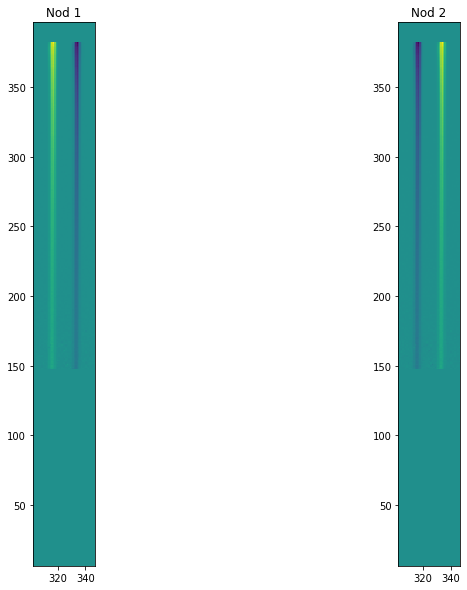

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[12,10])
ax[0].imshow(sp2[0].data, origin='lower', aspect='equal', interpolation='None')
ax[0].set_title('Nod 1')
ax[0].set_xlim([sp2[0].meta.wcs.bounding_box[0][0], sp2[0].meta.wcs.bounding_box[0][1]])
ax[0].set_ylim([sp2[0].meta.wcs.bounding_box[1][0], sp2[0].meta.wcs.bounding_box[1][1]])

ax[1].imshow(sp2[1].data, origin='lower', aspect='equal', interpolation='None')
ax[1].set_title('Nod 2')
ax[1].set_xlim([sp2[1].meta.wcs.bounding_box[0][0], sp2[1].meta.wcs.bounding_box[0][1]])
ax[1].set_ylim([sp2[1].meta.wcs.bounding_box[1][0], sp2[1].meta.wcs.bounding_box[1][1]])



## Checking the Photom() output

We retrieve the reference file from crds and use that to perform an arithmetic check that the calibration step is correctly implemented at 5 randomly chosen test locations in the bounding box. We also perform a check that the WCS information is consistent between the nods.

2021-01-25 10:54:00,538 - stpipe - WARNING - <ipython-input-15-cb6a1a66f00a>:34: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  ffig.show()



Point x    Point y   Wavelength
********************************
  317       290   8.700
  317       250   9.780
  310       225   10.383
  334       310    8.089
  340       200   10.939


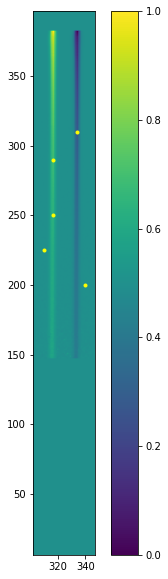

In [15]:
ffig = plt.figure(figsize=[6,10])
print('Point x    Point y   Wavelength')
print('********************************')

point1 = (317,290)
ra1, dec1, wave1 = sp2[0].meta.wcs(point1[0],point1[1])
print('  {0}       {1}   {2:.3f}'.format(point1[0], point1[1], wave1))


point2 = (317,250)
ra2, dec2, wave2 = sp2[0].meta.wcs(point2[0],point2[1])
print('  {0}       {1}   {2:.3f}'.format(point2[0], point2[1], wave2))
point3 = (310,225)
ra3, dec3, wave3 = sp2[0].meta.wcs(point3[0],point3[1])
print('  {0}       {1}   {2:.3f}'.format(point3[0], point3[1], wave3))
point4 = (334,310)
ra4, dec4, wave4 = sp2[0].meta.wcs(point4[0],point4[1])
print('  {0}       {1}    {2:.3f}'.format(point4[0], point4[1], wave4))
point5 = (340,200)
ra5, dec5, wave5 = sp2[0].meta.wcs(point5[0],point5[1])
print('  {0}       {1}   {2:.3f}'.format(point5[0], point5[1], wave5))
plt.imshow(sp2[0].data, origin='lower', aspect='equal')

xpts = [point1[0], point2[0], point3[0], point4[0], point5[0]]
ypts = [point1[1], point2[1], point3[1], point4[1], point5[1]]


plt.xlim([sp2[0].meta.wcs.bounding_box[0][0], sp2[0].meta.wcs.bounding_box[0][1]])
plt.ylim([sp2[0].meta.wcs.bounding_box[1][0], sp2[0].meta.wcs.bounding_box[1][1]])


plt.scatter([point1[0],point2[0],point3[0],point4[0],point5[0]],[point1[1],point2[1],point3[1],point4[1],point5[1]], color='yellow', marker='.')
plt.colorbar()
ffig.show()

waves = [wave1, wave2, wave3, wave4, wave5]

2021-01-25 11:00:21,831 - stpipe - WARNING - <ipython-input-16-22a15362a6a6>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  ffig.show()



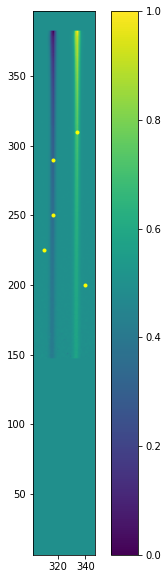

In [16]:
ffig = plt.figure(figsize=[6,10])
plt.imshow(sp2[1].data, origin='lower', aspect='equal')
plt.scatter([point1[0],point2[0],point3[0],point4[0],point5[0]],[point1[1],point2[1],point3[1],point4[1],point5[1]], color='yellow', marker='.')
#[317,317,310,334,340],[290,250,225,310,200]
plt.xlim([sp2[1].meta.wcs.bounding_box[0][0], sp2[1].meta.wcs.bounding_box[0][1]])
plt.ylim([sp2[1].meta.wcs.bounding_box[1][0], sp2[1].meta.wcs.bounding_box[1][1]])
plt.colorbar()

ra21, dec21, wave2_1 = sp2[1].meta.wcs(point1[0],point1[1])
ra22, dec22, wave2_2 = sp2[1].meta.wcs(point2[0],point2[1])
ra23, dec23, wave2_3 = sp2[1].meta.wcs(point3[0],point3[1])
ra24, dec24, wave2_4 = sp2[1].meta.wcs(point4[0],point4[1])
ra25, dec25, wave2_5 = sp2[1].meta.wcs(point5[0],point5[1])

waves2 = [wave2_1, wave2_2, wave2_3, wave2_4, wave2_5]

ffig.show()



Check that the WCS information matches for both nods.

In [17]:
assert(ww1 == ww2 for ww1, ww2 in zip(waves, waves2)), "wavelengths for points points don't match between nods"

Now we will check the photometric calibration arithmetic.

**Reminder** : The photom reference file contains a few single values, and then some columns. Amongst the initial single values is 'photmjsr', which is a conversion factor from DN/s to MJy/sr (reffile.phot_table['photmjsr']. Then there are wavelength and relresponse columns, which determine the wavelength-dependent part of the spectral response. At each given pixel, the DN/s slope value in the flat file output file is multiplied by a conversion factor conv_factor, where conv_factor = reffile.phot_table['photmjsr'] * reffile.phot_table['relresponse'] (wave)

In [18]:
reffile = [ss.meta.ref_file.photom.name for ss in sp2]
print(reffile)
assert reffile[0]==reffile[1], "Nods do not use the same Photom reference file"

# if this test passes and both nods use the same ref file, then just load in once and use for both.
basename = crds.core.config.pop_crds_uri(reffile[0])
filepath = crds.locate_file(basename, "jwst")
ref =  datamodels.open(filepath)

['crds://jwst_miri_photom_0072.fits', 'crds://jwst_miri_photom_0072.fits']


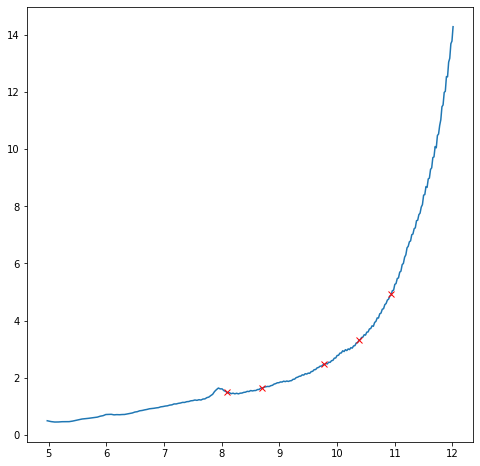

In [19]:
f = interpolate.interp1d(ref.phot_table['wavelength'][0,:], ref.phot_table['relresponse'][0,:])
iresp = [f(ww) for ww in waves]

# plot for sanity check!
plt.figure(figsize=[8,8])
plt.plot(ref.phot_table['wavelength'][0,:], ref.phot_table['relresponse'][0,:])
plt.plot(waves, iresp, 'rx', label='interpolated points')
plt.show()

Now create the list of conversion factors for each of these points.

In [20]:
fconv = [ref.phot_table['photmjsr'][0] * ir for ir in iresp]
print(fconv)



2021-01-25 11:01:14,629 - stpipe - WARNING - /Users/skendrew/anaconda3/envs/jwst0.17.1/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



[99.16736187311675, 149.3253436135427, 200.79434236498608, 90.11472248476873, 297.6782481253979]


In the next cell we check that these conversion factors match the ratio of the flat fielded data and the photom-calibrated data at the location of our chosen points.

In [21]:
ff_files = glob.glob('*flat_field.fits')
print(ff_files)
flat = []

for f in ff_files:
    ffs = datamodels.open(f)
    flat.append(ffs)

print(ff)
    
# make sure we are combining the right nods for both files
if 'nod1' in sp2[0].meta.filename:
    if 'nod2' in ff_files[0]:
        flat.reverse()

if 'nod2' in sp2[0].meta.filename:
    if 'nod1' in ff_files[0]:
        flat.reverse()

print([ss.meta.filename for ss in sp2])
print([fff.meta.filename for fff in flat])





['miri_lrs_slit_pt_nod2_v2_flat_field.fits', 'miri_lrs_slit_pt_nod1_v2_flat_field.fits']
/Users/skendrew/jwst_pipeline/jwst_validation_notebooks/jwst_validation_notebooks/photom/miri_lrs_slit_pt_nod2_v2.3.fits
['miri_lrs_slit_pt_nod1_v2_cal.fits', 'miri_lrs_slit_pt_nod2_v2_cal.fits']
['miri_lrs_slit_pt_nod1_v2_flat_field.fits', 'miri_lrs_slit_pt_nod2_v2_flat_field.fits']


2021-01-25 11:02:14,454 - stpipe - WARNING - /Users/skendrew/anaconda3/envs/jwst0.17.1/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

2021-01-25 11:02:14,571 - stpipe - WARNING - <ipython-input-22-d239f47e81f0>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()



((302.5, 346.5), (6.5, 396.5))


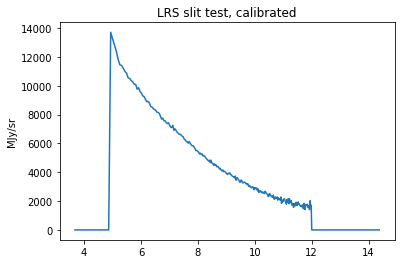

In [22]:
x,y = grid_from_bounding_box(flat[0].meta.wcs.bounding_box)
ra, dec, lam = flat[0].meta.wcs(x, y)

lam_vec = np.mean(lam, axis=1)

print(flat[0].meta.wcs.bounding_box)

flat_test = flat[0].data[6:396, :]
pho_test = sp2[0].data[6:396, :]

fig = plt.figure()
plt.plot(lam_vec, pho_test[:,318])
#plt.plot(lam_vec, flat_test[:,318])
plt.title('LRS slit test, calibrated')
plt.ylabel('MJy/sr')
plt.savefig('photom_slit_test_cal.png')
fig.show()


In [23]:
dratio = [sp2[0].data[yy,xx]/flat[0].data[yy,xx] for xx,yy in zip(xpts, ypts)]

# print these numbers next to each other to see if they match
print('Ratio of data points     Calculated conversion factor')
for rr, ff in zip(dratio, fconv):
    print('{0:.5f}                {1:.5f}'.format(rr,ff))
    assert np.isclose(rr,ff, rtol=1e-6), "Numbers don't match to within 1e-6"




2021-01-25 11:02:35,306 - stpipe - WARNING - /Users/skendrew/anaconda3/envs/jwst0.17.1/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Ratio of data points     Calculated conversion factor
99.16736                99.16736
149.32535                149.32534
200.79434                200.79434
90.11472                90.11472
297.67825                297.67825


Now check the same for Nod 2

In [24]:
dratio2 = [sp2[1].data[yy,xx]/flat[1].data[yy,xx] for xx,yy in zip(xpts, ypts)]

# print these numbers next to each other to see if they match
print('Ratio of data points     Calculated conversion factor')
for rr, ff in zip(dratio, fconv):
    print('{0:.5f}                {1:.5f}'.format(rr,ff))
    assert np.isclose(rr,ff, rtol=1e-6), "Numbers don't match to within 1e-6"



Ratio of data points     Calculated conversion factor
99.16736                99.16736
149.32535                149.32534
200.79434                200.79434
90.11472                90.11472
297.67825                297.67825


If these tests return no AssertionErrors, the test has passed.

Authors:
* K. Murray, kmurray@stsci.edu, MIRI Branch
* S. Kendrew, ssarah.kendrew@esa.int, ESA/MIRI Branch

Last updated:
Jan 14th 2021